In [1]:
import cdh23.loadData
import cdh23.analyzeData

mice = ['m900']

data = cdh23.loadData.loadTheData(mice)

------------------
Mouse: m900
------------------
Loading data...
Date: 220804
Calculating dF...
Neurons x Time: (1363, 14000)
Loading stim history...


----------------
ANALYZING MOUSE: m900
----------------
Aalyzing session: 1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

PCs: (0, 1)
t_type: 4 kHz
t_type: 8 kHz
t_type: 16 kHz
t_type: 32 kHz
t_type: 64 kHz
PCs: (1, 2)
t_type: 4 kHz
t_type: 8 kHz
t_type: 16 kHz
t_type: 32 kHz
t_type: 64 kHz
PCs: (0, 2)
t_type: 4 kHz
t_type: 8 kHz
t_type: 16 kHz
t_type: 32 kHz
t_type: 64 kHz


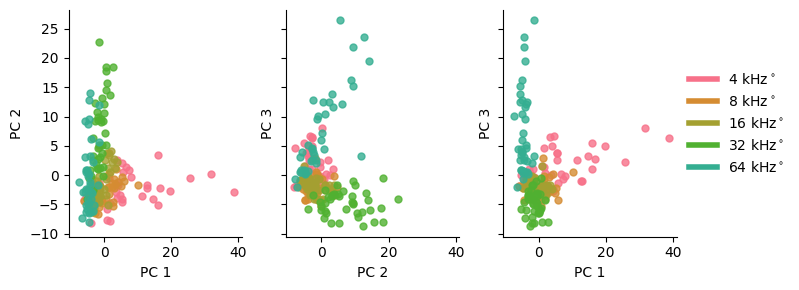

In [2]:


for mouse in mice :
        print("----------------")
        print("ANALYZING MOUSE:", mouse)
        print("----------------")
        ordered = data.processAndSort(mouse)
        sessions = len(ordered[0])
        for i in range(sessions):
            print("Aalyzing session:", i + 1)
            analyzer = cdh23.analyzeData.analyzeTheData(ordered[0][i], ordered[1][i], mouse, "F1_Ahl")
            trainingData = analyzer.trial_response_pca()
            #analyzer.trial_average_pca()
            #analyzer.threeDtrajectories()
            #analyzer.twoD_vid()

In [189]:
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

pal = sns.color_palette('husl', 9)

def add_orientation_legend(ax):
        trial_types = ['4 kHz', '8 kHz', '16 kHz', '32 kHz', '64 kHz']
        custom_lines = [Line2D([0], [0], color=pal[k], lw=4) for
                    k in range(len(trial_types))]
        labels = ['{}$^\circ$'.format(t) for t in trial_types]
        ax.legend(custom_lines, labels,
              frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0,0,0.9,1])

Trials: 200 || Test %: 0.4 || Test Trials: 80.0


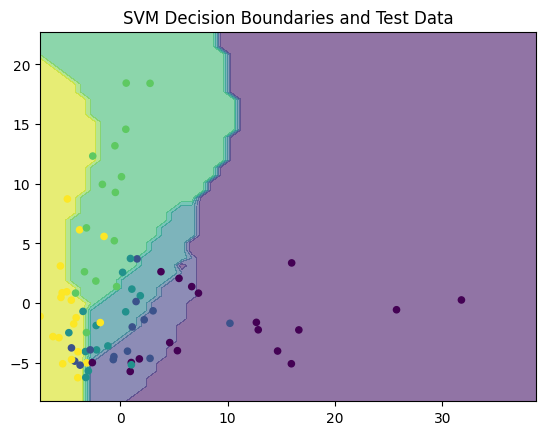

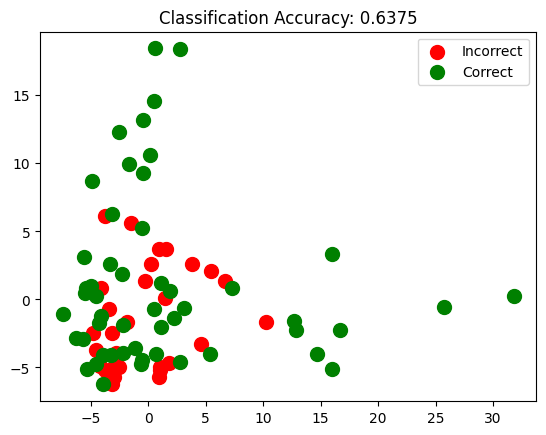

Accuracy: 0.6375
P-Value: 2.1101235452431725e-17


Text(0.5, 1.0, 'Confusion Matrix, p =2.1101235452431725e-17')

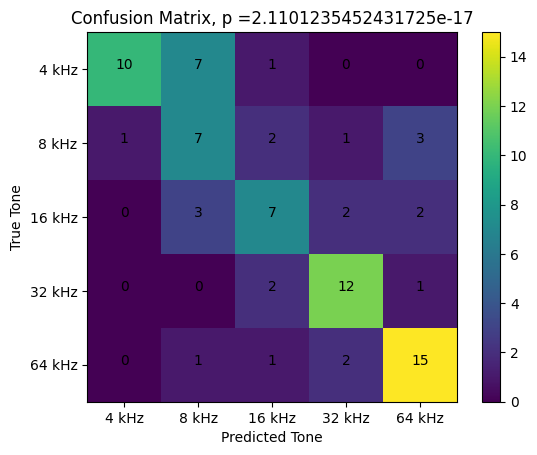

In [228]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from scipy import stats
import itertools
import seaborn as sns
from sklearn import svm

pcscape = 0
trials = 200
test_sz=0.40
testTrials = test_sz*trials

pal = sns.color_palette('husl', 6)

print("Trials:", trials, "|| Test %:", test_sz, "|| Test Trials:", testTrials)

y = np.zeros(trials)
for i in range(trials) :
    if i < 40 :
        y[i] = 0
    elif i < 80 :
        y[i] = 1
    elif i < 120 :
        y[i] = 2
    elif i < 160 :
        y[i] = 3
    elif i < 200 :
        y[i] = 4

X_train, X_test, y_train, y_test = train_test_split(trainingData[pcscape], y, test_size = test_sz, random_state=2)
#classifier = RandomForestClassifier(max_depth=2, random_state=1)
classifier = svm.SVC(decision_function_shape = 'ovo')

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)



if X_test[:, 0].min() < X_train[:, 0].min() :
    zerMin = X_test[:, 0].min()
else :
    zerMin = X_train[:, 0].min()

if X_test[:, 1].min() < X_train[:, 1].min() :
    oneMin = X_test[:, 1].min()
else :
    oneMin = X_train[:, 1].min()

if X_test[:, 0].max() > X_train[:, 0].max() :
    zerMax = X_test[:, 0].max()
else :
    zerMax = X_train[:, 0].max()

if X_test[:, 1].max() > X_train[:, 1].max() :
    oneMax = X_test[:, 1].max()
else :
    oneMax = X_train[:, 1].max()

feature_1, feature_2 = np.meshgrid(
    np.linspace(zerMin, zerMax),
    np.linspace(oneMin, oneMax))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
deb = np.reshape(classifier.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=deb)
display.plot( alpha=0.6)
display.ax_.scatter(X_test[:, 0], X_test[:, 1], c = y_test,s=20)
plt.title("SVM Decision Boundaries and Test Data")


acc_labels = np.zeros(len(y_pred))
for i in range(len(y_pred)) :
    if y_pred[i] == y_test[i] :
        acc_labels[i] = 1

cdict = {0.0: 'red', 1.0: 'green'}

fig, ax = plt.subplots()
for g in np.unique(acc_labels):
    ix = np.where(acc_labels == g)
    ax.scatter(X_test[ix, 0], X_test[ix, 1], c = cdict[g], s = 100)

ax.legend(['Incorrect', "Correct"])
plt.title("Classification Accuracy: " + str(accuracy_score(y_test, y_pred)))

plt.show()

plt.xlabel("Predicted Tone")
plt.ylabel("True Tone")
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center")
plt.colorbar()
plt.yticks([0, 1, 2, 3, 4], ['4 kHz', '8 kHz', '16 kHz', '32 kHz', '64 kHz'])
plt.xticks([0, 1, 2, 3, 4], ['4 kHz', '8 kHz', '16 kHz', '32 kHz', '64 kHz'])
pval = stats.binom_test(testTrials * accuracy_score(y_test, y_pred), n=testTrials, p=.2, alternative='greater')
print('Accuracy:', str(accuracy_score(y_test, y_pred)))
print("P-Value:", pval)
plt.title("Confusion Matrix, p =" + str(pval))

[[6 0 1 0 1]
 [4 0 4 1 1]
 [1 0 4 0 1]
 [0 0 2 5 0]
 [0 0 1 0 8]]
Accuracy: 0.575
P-Value: 2.0282597642980467e-07


Text(0.5, 1.0, 'Confusion Matrix, p =2.0282597642980467e-07')

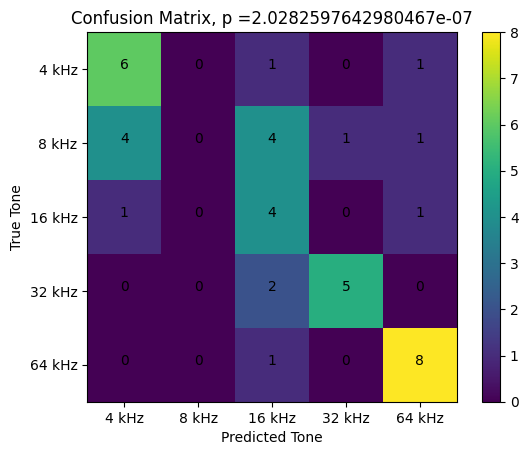

In [61]:
from scipy import stats
import itertools
#plt.scatter(X_test[:, 0], X_test[:, 1], y_test, c=y_test, label=y_test)
plt.figure()
plt.xlabel("Predicted Tone")
plt.ylabel("True Tone")
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center")
plt.colorbar()
plt.yticks([0, 1, 2, 3, 4], ['4 kHz', '8 kHz', '16 kHz', '32 kHz', '64 kHz'])
plt.xticks([0, 1, 2, 3, 4], ['4 kHz', '8 kHz', '16 kHz', '32 kHz', '64 kHz'])
print(cm)
pval = stats.binom_test(40* accuracy_score(y_test, y_pred), n=40, p=0.2, alternative='greater')
print('Accuracy:', str(accuracy_score(y_test, y_pred)))
print("P-Value:", pval)
plt.title("Confusion Matrix, p =" + str(pval))
